In [1]:
# !pip list -v

In [2]:
!pip install talib-binary
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import talib as ta
import joblib
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import yfinance as yahoo_finance

In [5]:
#suppress 'SettingWithCopy' warning
pd.set_option('mode.chained_assignment', None)

In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

In [8]:
# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False) 

In [9]:
#optional 
#yahoo_finance.pdr_override()

In [10]:
%matplotlib inline

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [12]:
# ___variables___
#ticker = 'TSLA'
#ticker = 'AAPL'
#ticker = 'NFLX'
#ticker = 'MSFT'
#ticker = 'NFLX'
#ticker = 'GOOGL'
#ticker = 'AMZN'
ticker = 'MOS'
#ticker = 'TLT'
#ticker = 'IBM'
#ticker = 'F'
#ticker = 'C'
#ticker = 'PG'
#ticker = 'JNJ'
# ticker = 'SWK' # Stanley Black & Decker
# ticker = "PPIACO" # PPI

start_time = datetime.datetime(1900, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [13]:
def get_data(ticker):
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

In [14]:
df = get_data(ticker)

connected to yahoo


In [15]:
# df.head()

In [16]:
df = df.sort_values(by="Date")

In [17]:
df.head()

Date     High      Low     Open    Close     Volume  Adj Close
0 1988-01-26  11.7500  11.2500  11.5000  11.5000  7244600.0   7.283535
1 1988-01-27  12.3750  11.4375  11.5625  12.3750  3652400.0   7.837715
2 1988-01-28  12.5625  12.1250  12.2500  12.5625  2180000.0   7.956469
3 1988-01-29  12.5625  11.8750  12.4375  12.2500  1335400.0   7.758543
4 1988-02-01  12.2500  11.9375  12.1250  12.0000   488800.0   7.600209

### Compute various stock technical indicators
For each stock we compute several technical indicators, we use mainly exponential moving averages, Bollinger Bands, RSI and so on. We will then feed these into neural network as features (or values derived from these indicators).

In [18]:
def compute_technical_indicators(df):
    # df['EMA5'] = ta.EMA(df['Adj Close'].values, timeperiod=5)
    # df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    # df['EMA15'] = ta.EMA(df['Adj Close'].values, timeperiod=15)
    # df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    # df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    # df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)
    df['MA50'] = ta.MA(df['Adj Close'].values, timeperiod=50)

    # df['EMA60'] = ta.EMA(df['Adj Close'].values, timeperiod=60)
    # df['EMA70'] = ta.EMA(df['Adj Close'].values, timeperiod=70)
    # df['EMA80'] = ta.EMA(df['Adj Close'].values, timeperiod=80)
    # df['EMA90'] = ta.EMA(df['Adj Close'].values, timeperiod=90)
    
    df['MA100'] = ta.MA(df['Adj Close'].values, timeperiod=100)
    # df['EMA150'] = ta.EMA(df['Adj Close'].values, timeperiod=150)
    df['MA200'] = ta.MA(df['Adj Close'].values, timeperiod=200)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Adj Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    df['SAR'] = ta.SAR(df['High'].values, df['Low'].values, acceleration=0.02, maximum=0.2)

    # we will normalize RSI
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

    df['normRSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14) / 100.0

    # My new additions
    df["LR100Day"] = ta.LINEARREG(df['Adj Close'].values, timeperiod=100)
    df["LR200Day"] = ta.LINEARREG(df['Adj Close'].values, timeperiod=200)

    df["CDL3LINESTRIKE"] = ta.CDL3LINESTRIKE(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
    df["CDL3WHITESOLDIERS"] = ta.CDL3WHITESOLDIERS(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
    df["CDLENGULFING"] = ta.CDLENGULFING(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
    df["CDLHAMMER"] = ta.CDLHAMMER(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
    df["CDLINVERTEDHAMMER"] = ta.CDLINVERTEDHAMMER(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
    df["CDLMORNINGSTAR"] = ta.CDLMORNINGSTAR(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
    df["CDLMORNINGDOJISTAR"] = ta.CDLMORNINGDOJISTAR(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)

    df.tail()

    return df

In [19]:
df = compute_technical_indicators(df)

In [20]:
df.tail()

Date       High        Low       Open      Close     Volume  Adj Close       MA50      MA100      MA200  ...   normRSI   LR100Day   LR200Day  CDL3LINESTRIKE  CDL3WHITESOLDIERS  CDLENGULFING  CDLHAMMER  CDLINVERTEDHAMMER  CDLMORNINGSTAR  CDLMORNINGDOJISTAR
8741 2022-10-03  49.980000  48.389999  49.330002  49.439999  5197500.0  49.439999  53.286298  52.994975  53.166893  ...  0.435440  50.688744  57.279543               0                  0             0          0                  0               0                   0
8742 2022-10-04  52.110001  50.220001  50.400002  52.090000  4722200.0  52.090000  53.320541  52.924250  53.246301  ...  0.506743  50.776432  57.088582               0                  0             0          0                  0               0                   0
8743 2022-10-05  52.169998  50.770000  51.590000  51.090000  3503000.0  51.090000  53.351739  52.850689  53.320758  ...  0.482004  50.814588  56.875300               0                  0             0          0                  0               0                   0
8744 2022-10-06  51.689999  50.279999  50.619999  51.310001  3938900.0  51.310001  53.358214  52.744006  53.400883  ...  0.487927  50.936428  56.655028               0                  0             0          0                  0               0                   0
8745 2022-10-07  51.619999  49.570000  50.900002  51.060001  3240000.0  51.060001  53.366072  52.626963  53.470871  ...  0.481194  51.070475  56.445174               0                  0             0          0                  0               0                   0

[5 rows x 25 columns]

In [21]:
df.loc[df["CDLENGULFING"] < 0, :].tail()

Date       High        Low       Open      Close      Volume  Adj Close       MA50      MA100      MA200  ...   normRSI   LR100Day   LR200Day  CDL3LINESTRIKE  CDL3WHITESOLDIERS  CDLENGULFING  CDLHAMMER  CDLINVERTEDHAMMER  CDLMORNINGSTAR  CDLMORNINGDOJISTAR
8643 2022-05-12  59.639999  56.299999  59.270000  58.740002   6960000.0  58.446068  65.267958  53.790827  44.562934  ...  0.396917  72.767195  63.987148               0                  0          -100        100                  0               0                   0
8671 2022-06-23  50.060001  45.150002  50.060001  45.240002  12948900.0  45.121655  61.111591  58.588654  48.108079  ...  0.284395  63.705546  65.569963               0                  0          -100          0                  0               0                   0
8722 2022-09-06  55.880001  53.910000  55.439999  54.009998   3641700.0  54.009998  51.226149  55.882727  51.614207  ...  0.481639  47.863374  60.771103               0                  0          -100          0                  0               0                   0
8726 2022-09-12  57.099998  51.880001  56.759998  52.439999   9943300.0  52.439999  51.687667  54.985401  51.969691  ...  0.449595  49.285023  60.327900               0                  0          -100          0                  0               0                   0
8733 2022-09-21  55.369999  53.310001  55.180000  53.500000   5145400.0  53.500000  52.883402  54.072352  52.632056  ...  0.481756  50.713542  59.280606               0                  0          -100          0                  0               0                   0

[5 rows x 25 columns]

In [22]:
def compute_features(df):
    # computes features for forest decisions
    # df['aboveEMA5'] = np.where(df['Adj Close'] > df['EMA5'], 1, 0)
    # df['aboveEMA10'] = np.where(df['Adj Close'] > df['EMA10'], 1, 0)
    # df['aboveEMA15'] = np.where(df['Adj Close'] > df['EMA15'], 1, 0)
    # df['aboveEMA20'] = np.where(df['Adj Close'] > df['EMA20'], 1, 0)
    # df['aboveEMA30'] = np.where(df['Adj Close'] > df['EMA30'], 1, 0)
    # df['aboveEMA40'] = np.where(df['Adj Close'] > df['EMA40'], 1, 0)
    
    df['aboveMA50'] = np.where(df['Adj Close'] > df['MA50'], 1, 0)
    # df['aboveEMA60'] = np.where(df['Adj Close'] > df['EMA60'], 1, 0)
    # df['aboveEMA70'] = np.where(df['Adj Close'] > df['EMA70'], 1, 0)
    # df['aboveEMA80'] = np.where(df['Adj Close'] > df['EMA80'], 1, 0)
    # df['aboveEMA90'] = np.where(df['Adj Close'] > df['EMA90'], 1, 0)
    
    # df['aboveMA100'] = np.where(df['Adj Close'] > df['MA100'], 1, 0)
    # df['aboveEMA150'] = np.where(df['Adj Close'] > df['EMA150'], 1, 0)
    df['aboveMA200'] = np.where(df['Adj Close'] > df['MA200'], 1, 0)

    df['aboveUpperBB'] = np.where(df['Adj Close'] > df['upperBB'], 1, 0)
    df['belowLowerBB'] = np.where(df['Adj Close'] < df['lowerBB'], 1, 0)
    
    df['aboveSAR'] = np.where(df['Adj Close'] > df['SAR'], 1, 0)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, 0)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, 0)

    # My new additions
    df['upTrendMA'] = np.where(df['MA100'] > df['MA200'], 1, 0)
    df['upTrendLR'] = np.where(df['LR100Day'] > df['LR200Day'], 1, 0)
    df["3LineStrike"] = np.where(df["CDL3LINESTRIKE"] > 0, 1, 0)
    df["3WhiteSoldiers"] = np.where(df["CDL3WHITESOLDIERS"] > 0, 1, 0)
    df["BullishEngulfing"] = np.where(df["CDLENGULFING"] > 0, 1, 0)
    df["Hammer"] = np.where(df["CDLHAMMER"] > 0, 1, 0)
    df["InvertedHammer"] = np.where(df["CDLINVERTEDHAMMER"] > 0, 1, 0)
    df["MorningStar"] = np.where(df["CDLMORNINGSTAR"] > 0, 1, 0)
    df["MorningDojiStar"] = np.where(df["CDLMORNINGDOJISTAR"] > 0, 1, 0)

    # very important - cleanup NaN values, otherwise prediction does not work
    df=df.fillna(0).copy()
    
    df.tail()

    return df

In [23]:
df = compute_features(df)

In [24]:
df.tail()

Date       High        Low       Open      Close     Volume  Adj Close       MA50      MA100      MA200  ...  overboughtRSI  upTrendMA  upTrendLR  3LineStrike  3WhiteSoldiers  BullishEngulfing  Hammer  InvertedHammer  MorningStar  MorningDojiStar
8741 2022-10-03  49.980000  48.389999  49.330002  49.439999  5197500.0  49.439999  53.286298  52.994975  53.166893  ...              0          0          0            0               0                 0       0               0            0                0
8742 2022-10-04  52.110001  50.220001  50.400002  52.090000  4722200.0  52.090000  53.320541  52.924250  53.246301  ...              0          0          0            0               0                 0       0               0            0                0
8743 2022-10-05  52.169998  50.770000  51.590000  51.090000  3503000.0  51.090000  53.351739  52.850689  53.320758  ...              0          0          0            0               0                 0       0               0            0                0
8744 2022-10-06  51.689999  50.279999  50.619999  51.310001  3938900.0  51.310001  53.358214  52.744006  53.400883  ...              0          0          0            0               0                 0       0               0            0                0
8745 2022-10-07  51.619999  49.570000  50.900002  51.060001  3240000.0  51.060001  53.366072  52.626963  53.470871  ...              0          0          0            0               0                 0       0               0            0                0

[5 rows x 41 columns]

In [25]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title("Stock data " + str(ticker))
    plt.plot(df["Date"], df["Adj Close"])
    # plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [26]:
def define_target_condition(df):
    # price higher later - bad predictive results
    # df["target_cls"] = np.where(df["Adj Close"].shift(-34) > df["Adj Close"], 1, 0)
    
    # price above trend multiple days later
    df["target_cls"] = np.where(df["Adj Close"].shift(-34) > df["LR100Day"].shift(-34), 1, 0)
    
    # important - remove NaN values
    df = df.fillna(0).copy()
    
    df.tail()
    
    return df

In [27]:
df = define_target_condition(df)

In [28]:
df.tail()

Date       High        Low       Open      Close     Volume  Adj Close       MA50      MA100      MA200  ...  upTrendMA  upTrendLR  3LineStrike  3WhiteSoldiers  BullishEngulfing  Hammer  InvertedHammer  MorningStar  MorningDojiStar  target_cls
8741 2022-10-03  49.980000  48.389999  49.330002  49.439999  5197500.0  49.439999  53.286298  52.994975  53.166893  ...          0          0            0               0                 0       0               0            0                0           0
8742 2022-10-04  52.110001  50.220001  50.400002  52.090000  4722200.0  52.090000  53.320541  52.924250  53.246301  ...          0          0            0               0                 0       0               0            0                0           0
8743 2022-10-05  52.169998  50.770000  51.590000  51.090000  3503000.0  51.090000  53.351739  52.850689  53.320758  ...          0          0            0               0                 0       0               0            0                0           0
8744 2022-10-06  51.689999  50.279999  50.619999  51.310001  3938900.0  51.310001  53.358214  52.744006  53.400883  ...          0          0            0               0                 0       0               0            0                0           0
8745 2022-10-07  51.619999  49.570000  50.900002  51.060001  3240000.0  51.060001  53.366072  52.626963  53.470871  ...          0          0            0               0                 0       0               0            0                0           0

[5 rows x 42 columns]

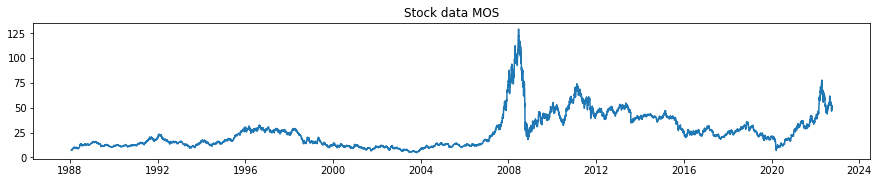

In [29]:
plot_train_data(df)

### Create one big training dataframe
Neural network will be trained on this dataframe. Data will be split eventually into training and testing set.

In [30]:
tickers = ['F', 'IBM', 'GE', 'AAPL', 'ADM', "C", "TLT", "AAP", "ORLY", "EPD",
           'XOM', 'GM','MMM','KO','PEP','SO','GS',
          'HAS','PEAK','HPE','HLT','HD','HON','HRL','HST','HPQ','HUM','ILMN', 
          'INTC','ICE','INTU','ISRG','IVZ','IRM','JNJ','JPM','JNPR','K','KMB', 
          'KIM', 'KMI','KSS','KHC', 'KR',
          'LEG', 'LIN', 'LMT','LOW',
          'MAR', 'MA','MCD','MDT', 'MRK',
          'MET', 'MGM', 'MU','MSFT', 'MAA',
          "SBK", "PG",
          'MNST', 'MCO','MS', 'MSI', 
          'MMM', 'ABT','ACN','ATVI','ADBE','AMD','A','AKAM','ARE','GOOG','AMZN','AAL',]

In [31]:
# parent dataframe to append to
ticker = "SPY"
df = get_data(ticker)
df = compute_technical_indicators(df)
df = compute_features(df)
df = define_target_condition(df)

connected to yahoo


In [32]:
for ticker in tickers:
    t_df = get_data(ticker)
    t_df = compute_technical_indicators(t_df)
    t_df = compute_features(t_df)
    t_df = define_target_condition(t_df)
    
    df = pd.concat([df, t_df], ignore_index=True)

connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to

In [33]:
df.tail()

Date   High    Low   Open  Close      Volume  Adj Close     MA50    MA100     MA200  ...  upTrendMA  upTrendLR  3LineStrike  3WhiteSoldiers  BullishEngulfing  Hammer  InvertedHammer  MorningStar  MorningDojiStar  target_cls
703656 2022-10-03  12.23  11.65  12.02  11.92  41156700.0      11.92  13.8250  14.3881  15.93315  ...          0          0            0               0                 0       0               0            0                0           0
703657 2022-10-04  13.05  12.30  12.31  12.95  47616000.0      12.95  13.8090  14.3579  15.91530  ...          0          0            0               0                 0       0               0            0                0           0
703658 2022-10-05  12.96  12.43  12.63  12.87  28172500.0      12.87  13.7978  14.3317  15.89490  ...          0          0            0               0                 0       0               0            0                0           0
703659 2022-10-06  13.00  12.40  12.77  12.73  31569300.0      12.73  13.7730  14.2932  15.87205  ...          0          0            0               0                 0       0               0            0                0           0
703660 2022-10-07  12.54  11.95  12.50  12.18  37269800.0      12.18  13.7414  14.2495  15.84235  ...          0          0            0               0                 0       0               0            0                0           0

[5 rows x 42 columns]

In [34]:
df.shape

(703661, 42)

In [35]:
more_tickers = [
    "GLD",
    "SLV",
    "SILJ",
    "SIL",
    "GDX",
    "GDXJ",
    "FNV",
    "NEM",
    "RGLD",
    "GOLD",
]

In [36]:
for ticker in more_tickers:
    t_df = get_data(ticker)
    t_df = compute_technical_indicators(t_df)
    t_df = compute_features(t_df)
    t_df = define_target_condition(t_df)
    
    df = pd.concat([df, t_df], ignore_index=True)

connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo


In [37]:
df.shape

(759683, 42)

## Train-Test split and Training part

In [43]:
# predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
#                    'aboveEMA5','aboveEMA10','aboveEMA15','aboveEMA20','aboveEMA30','aboveEMA40',
#                    'aboveEMA50','aboveEMA60','aboveEMA70','aboveEMA80','aboveEMA90','aboveEMA100']
predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
                   'aboveMA50', 'aboveMA200', "upTrendLR", "upTrendMA", "3LineStrike", "3WhiteSoldiers",
                   "BullishEngulfing", "Hammer", "InvertedHammer", "MorningStar", "MorningDojiStar"]

In [44]:
def splitting_and_training(df, predictors_list, test_size=0.3):
    # __predictors__
    
    # __features__
    X = df[predictors_list].fillna(0).values
    
    # __targets__
    y_cls = df.target_cls.fillna(0).values
    # y_cls.tail(10)
    
    # __train test split__
    from sklearn.model_selection import train_test_split
    y = y_cls
    X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    print ("X_cls_train.shape:", X_cls_train.shape)
    print ("y_cls_train.shape:", y_cls_train.shape)
    print ("X_cls_test.shape:", X_cls_test.shape)
    print ("y_cls_test.shape:", y_cls_test.shape)
    
    return X_cls_train, X_cls_test, y_cls_train, y_cls_test

## Neural Network

In [40]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
import torch.nn.functional as F

In [45]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 30)
        self.layer3 = nn.Linear(30, 2)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.drop(x)
        x = F.relu(self.layer2(x))
        x = self.drop(x)
        x = F.softmax(self.layer3(x)) # To check with the loss function
        
        return x

## Features & Labels

In [46]:
# so far the variables are dataframes, not arrays or tensors
features_train, features_test, labels_train, labels_test = splitting_and_training(df, predictors_list)

X_cls_train.shape: (531778, 17)
y_cls_train.shape: (531778,)
X_cls_test.shape: (227905, 17)
y_cls_test.shape: (227905,)


In [47]:
features_train[:3]

array([[0.        , 0.        , 0.        , 0.47512927, 0.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.47869024, 0.        ,
        0.        , 0.        , 1.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.4529461 , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [48]:
labels_train[:3]

array([0, 1, 1])

In [49]:
# make data tensors
features_train = Variable(torch.Tensor(features_train).float())
features_test = Variable(torch.Tensor(features_test).float())
labels_train = Variable(torch.Tensor(labels_train).long())
labels_test = Variable(torch.Tensor(labels_test).long())

x_train = features_train
y_train = labels_train

In [51]:
# Training
model = Model(features_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
epochs = 250
# epochs = 10 # starting small for testing

def print_(loss):
    print("The loss calculated:", loss)

## Actual Training Using Several Epochs

In [52]:
for epoch in range(1, epochs+1):
    print ("Epoch #", epoch)
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    print_(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

Epoch # 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


The loss calculated: 0.6930667757987976
Epoch # 2
The loss calculated: 0.6889414191246033
Epoch # 3
The loss calculated: 0.6847856640815735
Epoch # 4
The loss calculated: 0.6801096200942993
Epoch # 5
The loss calculated: 0.675054669380188
Epoch # 6
The loss calculated: 0.6697238087654114
Epoch # 7
The loss calculated: 0.6641478538513184
Epoch # 8
The loss calculated: 0.6588072180747986
Epoch # 9
The loss calculated: 0.6541982889175415
Epoch # 10
The loss calculated: 0.6502383351325989
Epoch # 11
The loss calculated: 0.6471039056777954
Epoch # 12
The loss calculated: 0.6446722149848938
Epoch # 13
The loss calculated: 0.643032431602478
Epoch # 14
The loss calculated: 0.6424338221549988
Epoch # 15
The loss calculated: 0.6418172717094421
Epoch # 16
The loss calculated: 0.6419863700866699
Epoch # 17
The loss calculated: 0.6417888402938843
Epoch # 18
The loss calculated: 0.6420364379882812
Epoch # 19
The loss calculated: 0.642114520072937
Epoch # 20
The loss calculated: 0.6421688199043274
Ep

In [53]:
# Prediction
x_test = features_test
pred = model(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [54]:
pred = pred.detach().numpy()

In [55]:
pred

array([[0.63433075, 0.36566922],
       [0.2856654 , 0.71433455],
       [0.33491254, 0.6650874 ],
       ...,
       [0.8827327 , 0.11726726],
       [0.89606297, 0.10393704],
       [0.34689748, 0.6531025 ]], dtype=float32)

In [56]:
len(pred)

227905

## Accuracy Evaluation

In [57]:
print ("The accuracy is", accuracy_score(labels_test, np.argmax(pred, axis=1)))

The accuracy is 0.6447642658125096


In [58]:
# Checking for first value
np.argmax(model(x_test[0]).detach().numpy(), axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0

In [59]:
labels_test[0]

tensor(1)

In [60]:
torch.save(model, "stocks-pytorch.pkl")

In [61]:
saved_model = torch.load("stocks-pytorch.pkl")

In [62]:
np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0

In [63]:
x_test[0]

tensor([0.0000, 0.0000, 0.0000, 0.3785, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [64]:
for i in x_test[:3]:
  print(i)
  prediction = np.argmax(saved_model(i).detach().numpy(), axis=0)
  print("Prediction:", prediction)

tensor([0.0000, 0.0000, 0.0000, 0.3785, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Prediction: 0
tensor([0.0000, 0.0000, 1.0000, 0.2784, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Prediction: 1
tensor([0.0000, 0.0000, 1.0000, 0.2302, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Prediction: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


## Prediction on Unknown Data
Let's provide the model with new stock data it was not trained on to see how it performs

In [65]:
# ticker = "DBA"
# ticker = "DBC"
# ticker = "EPD"
# ticker = "MPC"
# ticker = "MOS"
ticker = "SWN"

In [78]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(30,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', alpha=0.2)

    plt.plot(df['Date'], df['MA50'], label='MA50', alpha=0.2)
    plt.plot(df['Date'], df['MA200'], label='MA200', alpha=0.2)
    plt.plot(df['Date'], df['upTrendLR'], label='Up Trend LR', alpha=0.2)
    plt.plot(df['Date'], df['upTrendMA'], label='Up Trend MA', alpha=0.2)


    plt.scatter(df['Date'], df['Buy']*df['Adj Close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()

    return None  

In [67]:
new_df = get_data(ticker)

connected to yahoo


In [68]:
new_df = compute_technical_indicators(new_df)
new_df = compute_features(new_df)
new_df=define_target_condition(new_df)

In [69]:
saved_model

Model(
  (layer1): Linear(in_features=17, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [72]:
def predict_timeseries(df):
    
    # making sure we have good dimensions
    # column will be rewritten later
    df['Buy'] = df['target_cls']
    
    for i in range(len(df)):
        X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                        df['normRSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                        df['aboveMA50'][i],df['aboveMA200'][i],df['upTrendLR'][i],
                        df['upTrendMA'][i],df['3LineStrike'][i],df['3WhiteSoldiers'][i],
                        df['BullishEngulfing'][i],df['Hammer'][i],df['InvertedHammer'][i],
                        df['MorningStar'][i],df['MorningDojiStar'][i]]]

        x_test = Variable(torch.Tensor(X_cls_valid).float())    
        
        # print('x_test', x_test)
        

        # print('i', i)
        prediction = np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)
        # print('prediction', prediction)        
  
    
        df['Buy'][i] = prediction


    print(df.tail())    
        
    return df

In [79]:
new_df = predict_timeseries(new_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


            Date  High   Low  Open  Close      Volume  Adj Close    MA50   MA100    MA200  ...  upTrendLR  3LineStrike  3WhiteSoldiers  BullishEngulfing  Hammer  InvertedHammer  MorningStar  MorningDojiStar  target_cls  Buy
10728 2022-10-03  6.60  6.25  6.25   6.55  45017800.0       6.55  7.1414  7.2263  6.46070  ...          0            0               0                 0       0               0            0                0           0    1
10729 2022-10-04  7.10  6.61  6.70   7.08  48087000.0       7.08  7.1392  7.2310  6.47335  ...          0            0               0                 0       0               0            0                0           0    1
10730 2022-10-05  7.34  6.80  7.10   7.25  33467900.0       7.25  7.1386  7.2394  6.48705  ...          0            0               0                 0       0               0            0                0           0    1
10731 2022-10-06  7.33  6.93  7.19   6.95  27081500.0       6.95  7.1310  7.2431  6.50000  ...          

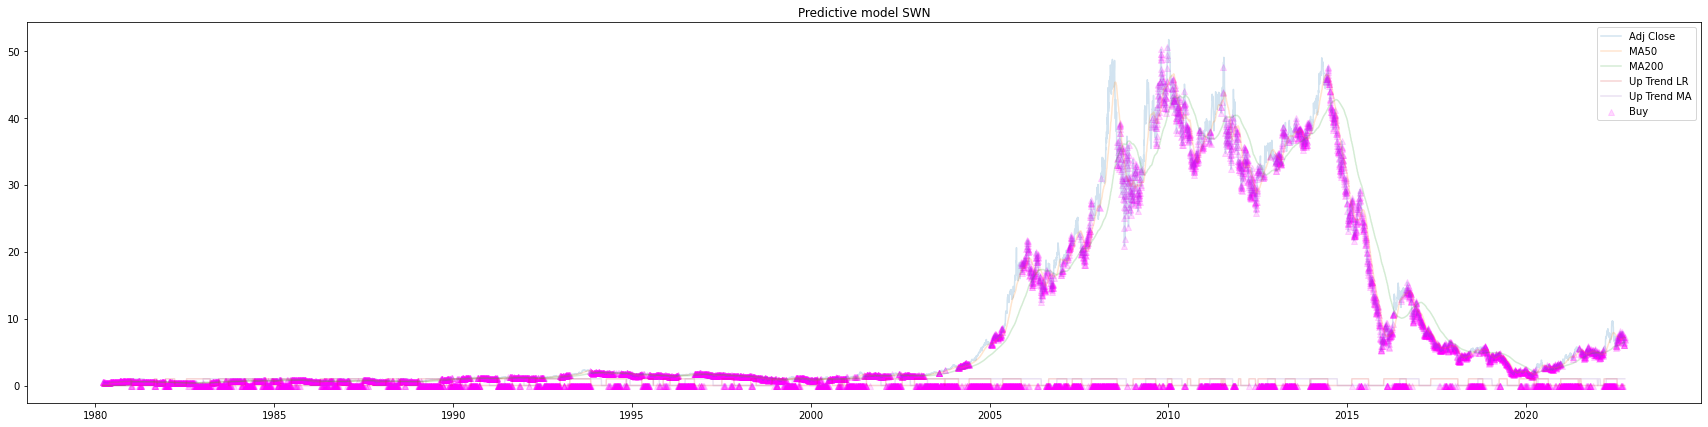

In [80]:
plot_stock_prediction(new_df, ticker)

In [81]:
new_df.shape

(10733, 43)

In [82]:
temp_df = new_df.loc[new_df["Date"] >= "2020-01-01", :]

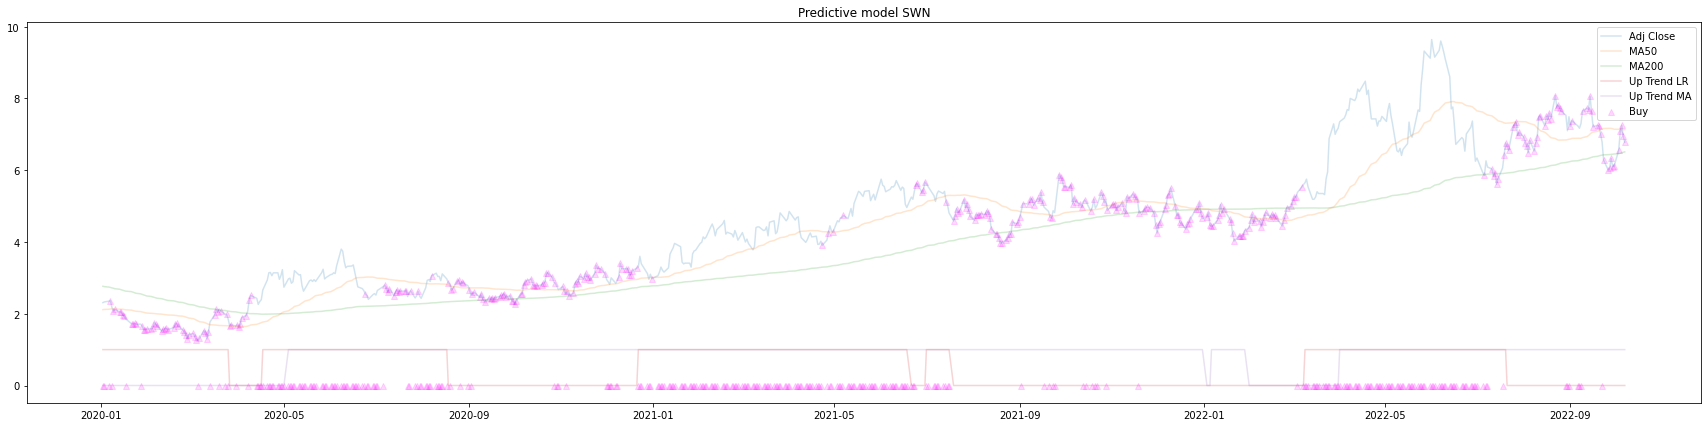

In [83]:
plot_stock_prediction(temp_df, ticker)